In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import gymnasium as gym
from gymnasium.spaces import Discrete


In [2]:
class DiscreteStatesDiscreteActions(gym.Env):
    """дискретные состояния, дискретные действия"""
    balance = 100
    reward = 0
    tick = 0
    def __init__(self, render_mode=None):
        self.observation_space = Discrete(3, seed=42)                       # {0, 1, 2}
        self.action_space = Discrete(3, seed=42)                            # {0, 1, 2}
        self.observation_in_words = ["снизилась","не изменилась","увеличилась"]
        self.action_in_words = ["продать","владеть","купить"]

    def _get_obs(self):
        return random.randint(0,2)

    def _get_info(self):
        return {"balance":self.balance}

    def step(self, action):
        observation = self._get_obs()

        old_balance = self.balance
        if  action ==0: self.balance +=1
        if  action ==2: self.balance -=1
        self.reward +=self.balance - old_balance                          #вознаграждение за правильное решение
        # if timecount % 10000 ==0:
        #     print("\tobservation\t", self.observation_in_words[observation],
        #         "\taction",self.action_in_words[action], f"\tбыло {old_balance:.4f} \tстало {self.balance:.4f}",f"\treward {self.reward:.4f}",timecount)

        terminated = self.balance <=0
        info = self._get_info()
        return observation, self.reward, terminated, False, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # print("reset",f"\tвознаграждение {self.reward:.2f}", f"\tбаланс {self.balance:.2f}","*"*20)
        self.balance = 100
        self.reward = 0
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def close(self):
        # print("\tclose",f"\tвознаграждение {self.reward:.2f}", f"\tбаланс {self.balance:.2f}","*"*20)
        pass


In [3]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    
    return np.random.choice(np.arange(action_n), p=policy)

In [4]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = []   # Создаем массив для хранения общих вознаграждений для каждого эпизода
    
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    qfunction = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями
    
    for episode in tqdm(range(episode_n)):  # Запускаем цикл для каждого эпизода
        epsilon = 1 / (episode + 1)  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом
        total_reward = 0  # Инициализируем общую сумму вознаграждений для каждого эпизода
        state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)  # Получаем действие с использованием epsilon-жадной стратегии
        
        for t_n in range(trajectory_len):  # Запускаем цикл для каждого шага внутри эпизода (ограниченного trajectory_len)
            next_state, reward, done, _, _ = env.step(action)  # Выполняем выбранное действие и получаем следующее состояние, вознаграждение и флаг завершения
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)  # Получаем следующее действие с использованием epsilon-жадной стратегии
            
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])  # Обновляем Q-функцию согласно формуле метода SARSA
            
            state = next_state  # Переходим в следующее состояние
            action = next_action  # Переходим в следующее действие
            total_reward += reward  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

            if done:  # Если эпизод завершился, выходим из цикла
                break
        
        total_rewards.append(total_reward) # Добавляем полученное вознаграждение к общему вознаграждению текущего эпизода
            
    return total_rewards  # Возвращаем массив общих вознаграждений для каждого эпизода

In [5]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    
    Q = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями
    epsilon = 1  # Инициализируем действием рандомный шанс
    
    total_rewards = []  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    for episode in tqdm(range(episode_n)):  # Запускаем цикл для каждого эпизода
        epsilon = 1 / (episode + 1)  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом
        total_reward = 0  # Инициализируем общую сумму вознаграждений для каждого эпизода
        state, _ = env.reset()  # Инициализируем состояние и действие в среде

        for t_n in range(t_max):  # Запускаем цикл для каждого шага в эпизоде
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)  # Делаем действие с шансом epsilon
            next_state, reward, done, _, _ = env.step(action)  # Делаем шаг в среде и получаем результат
            
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state][action])  # Обновляем Q-функцию
            
            total_reward += reward  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода
            
            if done:  # Если эпизод завершён, то выходим из цикла 
                break
                
            state = next_state  # Обновляем состояние в среде
            
        epsilon = max(0, epsilon - 1 / noisy_episode_n)  # Обновляем действием шанс
        
        total_rewards.append(total_reward)  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода
        
    return total_rewards  # Возвращаем общие вознаграждения для каждого эпизода

In [6]:
env = DiscreteStatesDiscreteActions()
env.action_space.seed(142)

[142]

100%|██████████| 1000/1000 [00:07<00:00, 130.85it/s]


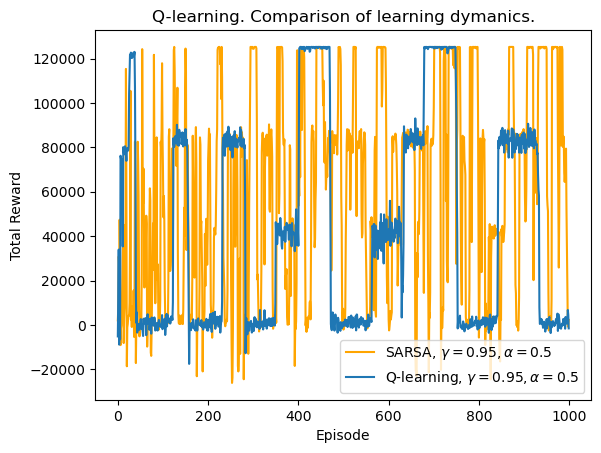

In [7]:
total_rewards_SARSA = SARSA(env, episode_n=1000, trajectory_len=500, gamma=0.99, alpha=0.5)
total_rewards_q_1 = QLearning(env, episode_n=1000, noisy_episode_n=400, t_max=500, gamma=0.999, alpha=0.5)

plt.plot(total_rewards_SARSA, color='orange', label='SARSA, $\gamma = 0.95, \\alpha=0.5$')
plt.plot(total_rewards_q_1, label='Q-learning, $\gamma = 0.95, \\alpha=0.5$')
plt.title('Q-learning. Comparison of learning dymanics.')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()